# Traveling Salesman Problem  (TSP)

# Example with random numbers

## Imports

In [11]:
from itertools import product
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import warnings

warnings.filterwarnings("ignore")
# filterwarnings() function is used to ignore warnings generated by the code.

## Code

In [12]:
# define TSP

n_customer = 19
n_point = n_customer + 1

# create DataFrame with random coordinates
df_tsp = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})

df_tsp.iloc[0]['x'] = 0
df_tsp.iloc[0]['y'] = 0

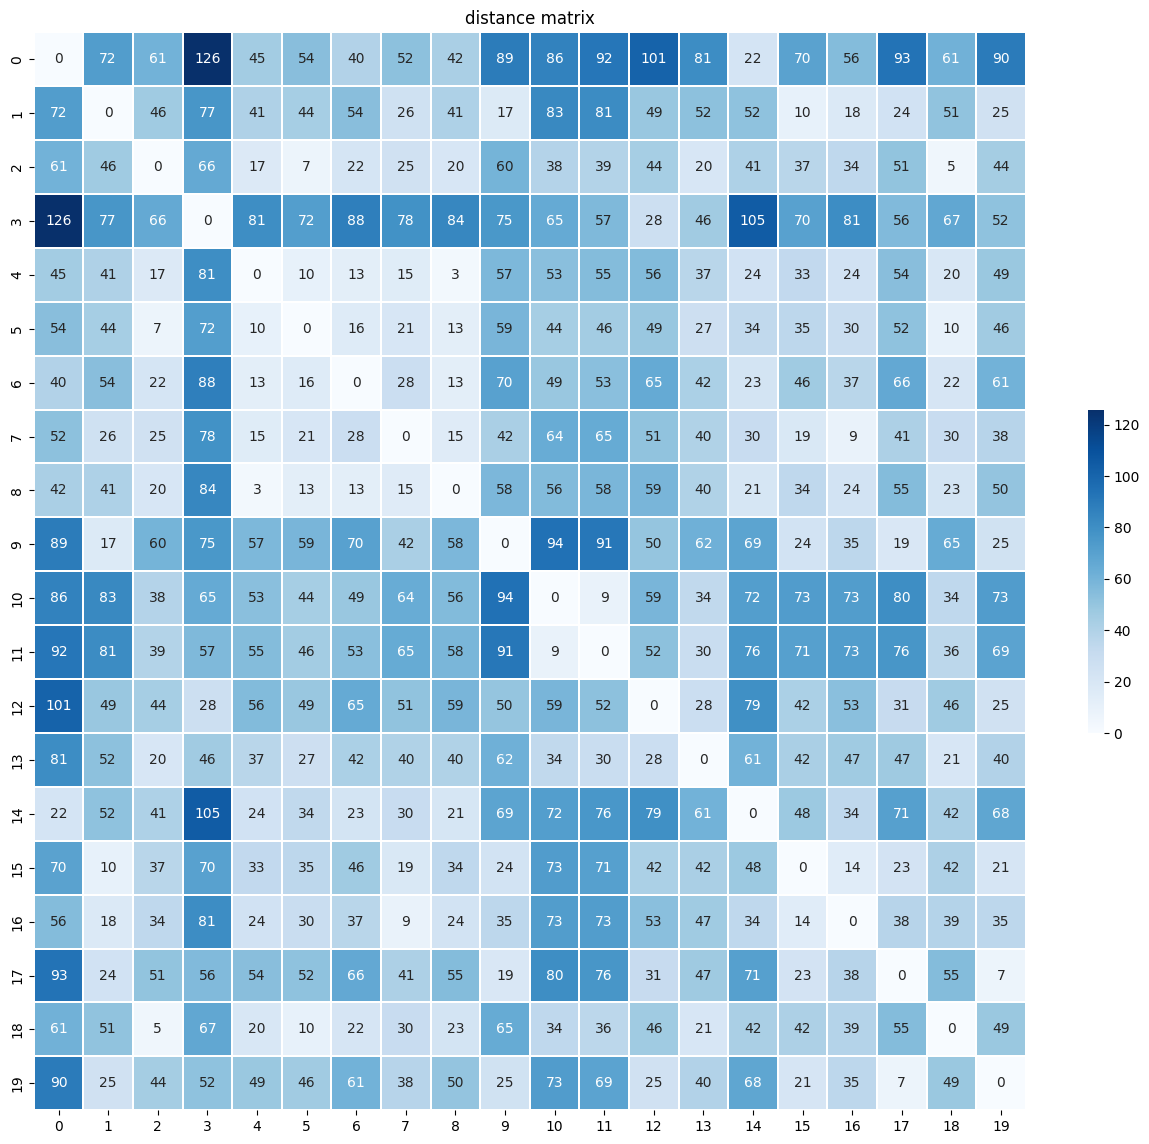

In [13]:
# Get the distance matrix between the cities

# In this case, we have a symmetric problem
distances = pd.DataFrame(distance_matrix(df_tsp[['x', 'y']].values, df_tsp[['x', 'y']].values), index=df_tsp.index,
                         columns=df_tsp.index).values

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3},
            linewidths=.1)  # Annot is for watch the numbers
plt.title('distance matrix')
plt.show()

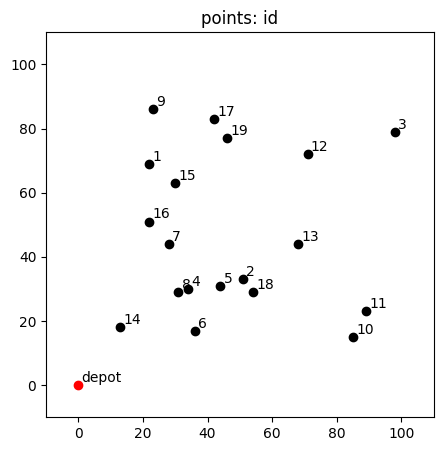

In [14]:
# display TSP instance

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df_tsp.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

In [16]:
%%time

# Set problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# set variables
x = pulp.LpVariable.dicts('x', ((i, j) for i, j in product(range(n_point), range(n_point))), cat=pulp.LpBinary)
# x[i,j] are binary variables that represent whether we travel from city i to city j in the tour or not
# lowBound=0 and upBound=1 mean that the variables can only take on the values of 0 or 1, respectively

# We need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', range(n_point), lowBound=1, upBound=n_point, cat=pulp.LpInteger)
# This line creates another dictionary of decision variables u[i], which are integer variables that represent the position of city i in the tour.

# set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i, j in product(range(n_point), range(n_point)))
# sets the objective function of the problem to minimize the total distance of the tour, which is calculated by summing the distances between each pair of 
# cities i and j multiplied by the decision variable x[i,j].

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0, f'c_no_loop_{i}'
    # adds a constraint to the problem that we cannot travel from a city to itself.

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1, f'c_leave_{i}'
    # adds a constraint to the problem that we must leave each city exactly once.
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1, f'c_enter_{i}'
    # adds a constraint to the problem that we must arrive at each city exactly once.

# eliminate subtour
for i, j in product(range(n_point), range(n_point)):
    if i != j and (i != 0 and j != 0):
        problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1, f'c_subtour_{i},{j}'
# adds the subtour elimination constraint that ensures that the solution does not contain any subtours. The constraint ensures that if we travel from city i 
# to city j, then the position of city i in the tour must be less than the position of city j in the tour, unless one of the cities is the starting city.

# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: total: 31.2 ms
Wall time: 51.5 s


(1, 'Optimal', 379.1696873307558)

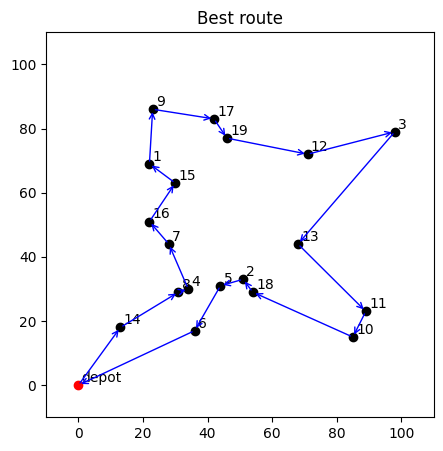

In [17]:
# visualize TSP solution

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df_tsp.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')

    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('Best route')

# draw optimal route
routes = [(i, j) for i in range(n_point) for j in range(n_point) if
          pulp.value(x[i, j]) >= 0.9]  # With the condition in the comprehension list we do the
# program only select the correct route
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df_tsp.iloc[j]['x'], df_tsp.iloc[j]['y']], xytext=[df_tsp.iloc[i]['x'], df_tsp.iloc[i]['y']],
                 arrowprops=arrowprops)
# This code block iterates over all pairs of cities in the routes list and adds an arrow between them to represent the optimal route. It uses the 
# plt.annotate() method from matplotlib to create the arrow. The xy parameter specifies the coordinates of the end point of the arrow, and the xytext 
# parameter specifies the coordinates of the start point of the arrow. The arrowprops parameter specifies the properties of the arrow.

plt.show()

# Example with real cities

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import folium  # For the graph
from geopy.geocoders import Nominatim
from geopy.distance import distance

## Code

In [19]:
# Create a geolocator object
geolocator = Nominatim(user_agent="my-app")

# Define the list of cities
cities = ["Berlin", "Hamburg", "Munich", "Cologne", "Frankfurt", "Stuttgart", "Düsseldorf", "Dortmund", "Essen",
          "Leipzig"]

# DataFrame for cities
df_cities = pd.DataFrame(index=cities, columns=["Latitude", "Longitude"])

# Create a new folium map centered on Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Loop through the list of cities and geocode each one
for city in cities:
    location = geolocator.geocode(city)
    if location is not None:
        print(f"{city}: ({location.latitude}, {location.longitude})")
        df_cities.loc[city]["Latitude"] = location.latitude
        df_cities.loc[city]["Longitude"] = location.longitude
        folium.Marker(location=df_cities.loc[city], popup=city).add_to(m)
    else:
        print(f"Could not geocode {city}")

# Display the map
m

Berlin: (52.5170365, 13.3888599)
Hamburg: (53.550341, 10.000654)
Munich: (48.1371079, 11.5753822)
Cologne: (50.938361, 6.959974)
Frankfurt: (50.1106444, 8.6820917)
Stuttgart: (48.7784485, 9.1800132)
Düsseldorf: (51.2254018, 6.7763137)
Dortmund: (51.5142273, 7.4652789)
Essen: (51.4582235, 7.0158171)
Leipzig: (51.3406321, 12.3747329)


In [20]:
df_cities.head()

,Latitude,Longitude
Berlin,52.517037,13.38886
Hamburg,53.550341,10.000654
Munich,48.137108,11.575382
Cologne,50.938361,6.959974
Frankfurt,50.110644,8.682092


In [21]:
# Calculation of the distance

dist = np.zeros(len(df_cities[['Latitude', 'Longitude']].values))
for i in range(0, len(df_cities[['Latitude', 'Longitude']].values)):
    l = np.array(
        [distance(df_cities[['Latitude', 'Longitude']].values[i],
                  df_cities[['Latitude', 'Longitude']].values[j]).km for
         j in range(0, len(df_cities[['Latitude', 'Longitude']].values))])
    dist = np.vstack((dist, l))
dist[1:]

array([[  0.        , 254.69437681, 503.98169487, 477.45412285,
        423.37153822, 511.25364022, 477.37170529, 421.56925675,
        453.2116522 , 148.31845848],
       [254.69437681,   0.        , 612.2828973 , 357.14859622,
        393.34221071, 533.96355335, 339.22147918, 284.45605321,
        308.61598311, 294.10205501],
       [503.98169487, 612.2828973 ,   0.        , 456.6385312 ,
        304.53602016, 190.97237742, 487.59260998, 477.91307275,
        493.98559298, 360.93133402],
       [477.45412285, 357.14859622, 456.6385312 ,   0.        ,
        152.93444605, 288.40998367,  34.42909166,  73.14674191,
         57.96734149, 381.50667558],
       [423.37153822, 393.34221071, 304.53602016, 152.93444605,
          0.        , 152.50005725, 183.10357972, 178.13719938,
        190.46664212, 294.41292233],
       [511.25364022, 533.96355335, 190.97237742, 288.40998367,
        152.50005725,   0.        , 322.10003931, 328.03730149,
        335.82941891, 365.37621943],
       [47

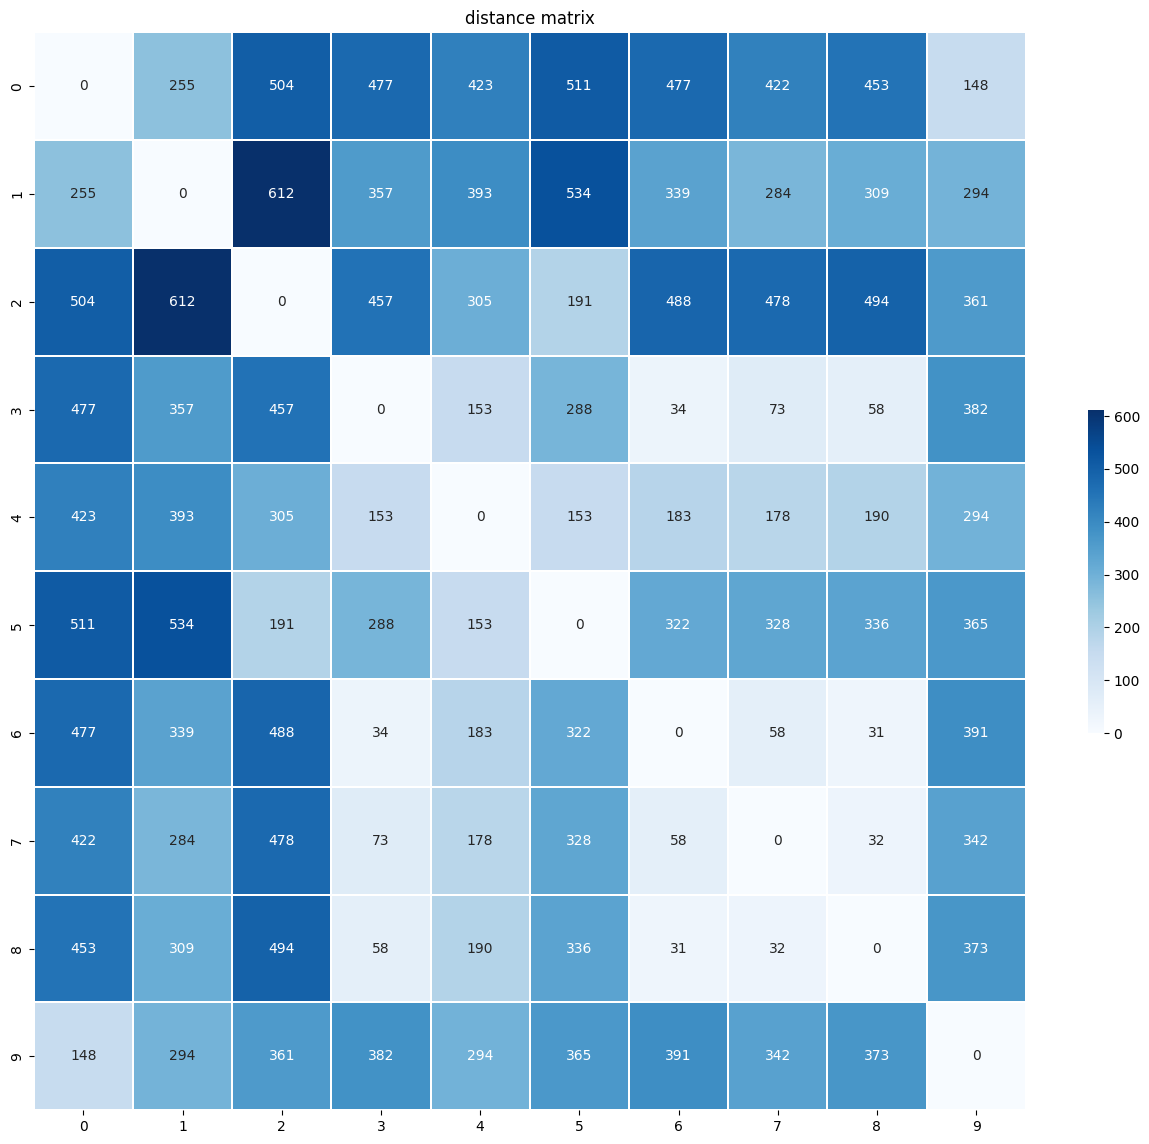

In [22]:
# Get the distance matrix between the cities

# In this case, we have a symmetric problem
distances = pd.DataFrame(dist[1:]).values

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3},
            linewidths=.1)  # Annot is for watch the numbers
plt.title('distance matrix')
plt.show()

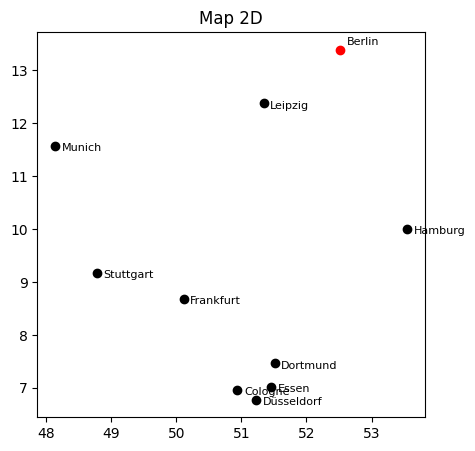

In [23]:
# check TSP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df_cities.iterrows():
    if i == 'Berlin':  # Berlin will be our starting point
        plt.scatter(row['Latitude'], row['Longitude'], c='r')
        plt.text(row['Latitude'] + 0.1, row['Longitude'] + 0.1, 'Berlin', fontsize=8)
    else:
        plt.scatter(row['Latitude'], row['Longitude'], c='black')
        plt.text(row['Latitude'] + 0.1, row['Longitude'] - 0.1, f'{i}', fontsize=8)

plt.title('Map 2D')
plt.show()

In [24]:
%%time

n_point = df_cities.shape[0]

# Set problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# set valiables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1,
                          cat='Binary')
# x[i,j] are binary variables that represent whether we travel from city i to city j in the tour or not
# lowBound=0 and upBound=1 mean that the variables can only take on the values of 0 or 1, respectively

# We need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point, cat='Integer')
# This line creates another dictionary of decision variables u[i], which are integer variables that represent the position of city i in the tour.

# set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point))
# sets the objective function of the problem to minimize the total distance of the tour, which is calculated by summing the distances between each pair of 
# cities i and j multiplied by the decision variable x[i,j].

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0  # adds a constraint to the problem that we cannot travel from a city to itself.

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(
        n_point)) == 1  # adds a constraint to the problem that we must leave each city exactly once.
    problem += pulp.lpSum(x[j, i] for j in range(
        n_point)) == 1  # adds a constraint to the problem that we must arrive at each city exactly once.

# eliminate subtour
for i in range(n_point):
    for j in range(n_point):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1
# adds the subtour elimination constraint that ensures that the solution does not contain any subtours. The constraint ensures that if we travel from city i 
# to city j, then the position of city i in the tour must be less than the position of city j in the tour, unless one of the cities is the starting city.

# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: total: 15.6 ms
Wall time: 287 ms


(1, 'Optimal', 1641.8853027590474)

In [27]:
round(2.345635355,5)

2.34564

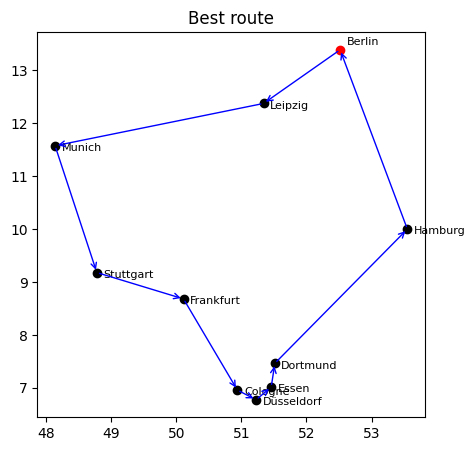

In [29]:
# check TSP problem and optimized route

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df_cities.iterrows():
    if i == 'Berlin':
        plt.scatter(row['Latitude'], row['Longitude'], c='r')
        plt.text(row['Latitude'] + 0.1, row['Longitude'] + 0.1, 'Berlin', fontsize=8)
    else:
        plt.scatter(row['Latitude'], row['Longitude'], c='black')
        plt.text(row['Latitude'] + 0.1, row['Longitude'] - 0.1, f'{i}', fontsize=8)

plt.title('Best route')

# draw optimal route
#routes = [(i, j) for i in range(n_point) for j in range(n_point) if
#          pulp.value(x[i, j]) == 1]  # With the condition in the comprehension list we do the

tol = 1e-6
routes = [(i, j) for i in range(n_point) for j in range(n_point) if 1 - pulp.value(x[i, j]) < tol]

# program only select the correct route
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df_cities.iloc[j]['Latitude'], df_cities.iloc[j]['Longitude']],
                 xytext=[df_cities.iloc[i]['Latitude'], df_cities.iloc[i]['Longitude']], arrowprops=arrowprops)
# This code block iterates over all pairs of cities in the routes list and adds an arrow between them to represent the optimal route. It uses the 
# plt.annotate() method from matplotlib to create the arrow. The xy parameter specifies the coordinates of the end point of the arrow, and the xytext 
# parameter specifies the coordinates of the start point of the arrow. The arrowprops parameter specifies the properties of the arrow.

plt.show()